In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torchvision import transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from scipy.stats import loguniform, randint

%matplotlib inline

In [2]:
with open("data/processed/training_data.pickle", "rb") as f:
    training_data = pickle.load(f)

with open("data/processed/training_arm.pickle", "rb") as f:
    training_arm = pickle.load(f)

with open("data/processed/mean_trajectory.pickle", "rb") as f:
    mean_trajectory = pickle.load(f)

with open("trained_models/lr.pickle", "rb") as f:
    lr = pickle.load(f)

In [3]:
class NeuralDecoder(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, 500),
            nn.ReLU(),
            nn.Linear(500, 1_000),
            nn.ReLU(),
            nn.Linear(1_000, 5_000),
            nn.ReLU(),
            nn.Linear(5_000, 10_000),
            nn.ReLU(),
            nn.Linear(10_000, 15_000),
            nn.ReLU(),
            nn.Linear(15_000, 10_000),
            nn.ReLU(),
            nn.Linear(10_000, 5_000),
            nn.ReLU(),
            nn.Linear(5_000, output_size)
        )

    def forward(self, x):
        out = self.main(x)
        return out


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nn = NeuralDecoder(input_size=297, output_size=3_000)
nn.load_state_dict(torch.load("trained_models/trained_nn.pt",
                              map_location=device))

<All keys matched successfully>

In [4]:
data = np.concatenate((training_data, training_arm), axis=1)
data.shape

(40000, 3298)

In [5]:
X_train, X_test, y_train_arm, y_test_arm = train_test_split(
    data[:, :297], data[:, 297:],
    test_size=0.3, random_state=2022
)

y_train = y_train_arm[:, 0]
y_test = y_test_arm[:, 0]

arm_train = y_train_arm[:, 1:]
arm_test = y_test_arm[:, 1:]

print(X_train.shape)
print(y_train.shape)
print(arm_train.shape)

(28000, 297)
(28000,)
(28000, 3000)


In [6]:
# Classifier
output_lr = lr.predict(X_test)
output_lr.shape

(12000,)

In [7]:
# If classifier predicted 1, 2, 3 or 4, use NN instead
# If classifier predicted 6, 7, use classifier
# If classifier predicted 5, 8, average mean and NN

prediction = np.zeros(arm_test.shape)

for idx, i in enumerate(output_lr):
    if (i < 5):
        prediction[idx, :] = nn(torch.Tensor(X_test[idx, :])).detach().numpy()
    elif (i == 6 or i == 7):
        prediction[idx, :] = mean_trajectory[f"dir_{int(i)}"]
    else:
        prediction[idx, :] = (
            nn(torch.Tensor(X_test[idx, :])).detach().numpy() +
            mean_trajectory[f"dir_{int(i)}"]) / 2

In [8]:
rmse = np.sqrt(np.mean((arm_test - prediction)**2))
print(rmse)

41.828833693768324


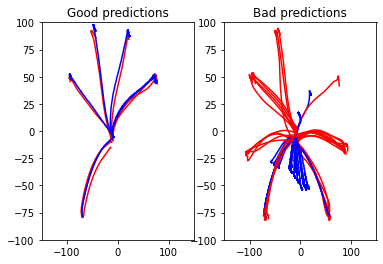

In [9]:
good_examples = 0
bad_examples = 0

ax_good = plt.subplot(121)
ax_bad = plt.subplot(122)

for idx in range(X_test.shape[0]):
    if good_examples < 30 and bad_examples < 30:
        pred = prediction[idx, :]
        actual = arm_test[idx, :]
        rmse = np.sqrt(np.mean((pred - actual)**2))
        if rmse < 5:
            good_examples += 1
            ax_good.plot(actual[:1000], actual[1000:2000], color="r")
            ax_good.plot(pred[:1000], pred[1000:2000], color="b")
        if rmse > 30:
            bad_examples += 1
            ax_bad.plot(actual[:1000], actual[1000:2000], color="r")
            ax_bad.plot(pred[:1000], pred[1000:2000], color="b")

ax_good.title.set_text("Good predictions")
ax_bad.title.set_text("Bad predictions")
ax_good.set_xlim([-150, 150])
ax_good.set_ylim([-100, 100])
ax_bad.set_xlim([-150, 150])
ax_bad.set_ylim([-100, 100])
plt.show()